# Classification de peintures :
### Aivazovsky, Van Gogh, Cortes et Renoir

<br>

## 1) Configuration du notebook 

Ces trois lignes sont propres à Jupyter et ne sont pas du Python :
elles servent à actualiser le code en cas de changement de librairie et de bien afficher les plots de matplotlib sur le notebook.

In [1]:
%reload_ext autoreload
%autoreload 2<br>
%matplotlib inline

On importe avec * tous les élements du module vision de la librairie FastAI et l'élément <strong>error_rate</strong> du module metrics.<br>
Metrics : Similarité entre deux éléments d'un même ensemble.

In [2]:
from fastai.vision import *
from fastai.metrics import accuracy

On définit par la variable path le chemin vers le dossier parents qui contient les fichiers .csv de nos différentes catégories d'images.

# 2) Importation des données

<br>

In [3]:
path = Path('paintings/')

On ajoute deux arguments à une boucle <strong>for</strong> : le nom des fichiers csv ainsi que le dossier (non existant) qui va télécharger les images comprises dans les .csv et les placer dans des sous-dossier de notre path.<br>

In [ ]:
for file, folder in [('aivazovsky.csv', 'Aivazovsky'), ('cortes.csv', 'Cortes'), ('vangogh.csv', 'VanGogh'), ('renoir.csv', 'Renoir')]:
    dest = path/folder
    dest.mkdir(parents=True, exist_ok=True)
    download_images(path/file, dest, max_pics=2000)

Error https://i.colnect.net/f/4924/694/Marine_Painting_by_Ivan_Aivazovsky_1858.jpg ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Error http://www.hugbear.net/bearworks/art/576.jpg HTTPSConnectionPool(host='www.hugbear.net', port=443): Max retries exceeded with url: /bearworks/art/576.jpg (Caused by SSLError(SSLError("bad handshake: Error([('SSL routines', 'tls_process_server_certificate', 'certificate verify failed')])")))
Error http://www.hugbear.net/bearworks/art/578.jpg HTTPSConnectionPool(host='www.hugbear.net', port=443): Max retries exceeded with url: /bearworks/art/578.jpg (Caused by SSLError(SSLError("bad handshake: Error([('SSL routines', 'tls_process_server_certificate', 'certificate verify failed')])")))


Toujours avec une boucle <strong>for</strong>, on vérifie les images avec verify_image et on supprime celles n'ayant pas pu être téléchargées.

In [ ]:
for folder in ('Aivazovsky', 'Cortes', 'VanGogh', 'Renoir'):
    print(folder)
    verify_images(path/folder, delete=True)

# 3) Préparation des données

<br>

On définit le seed personnalisé afin d'avoir le même tirage aléatoire à chaque fois.<br>
On crée une variable data dans laquelle on utilise la classe FastAI ImageDataBunch.<br>
En utilisant .from_folder, on crée un dataset de style image-net ressemblant à 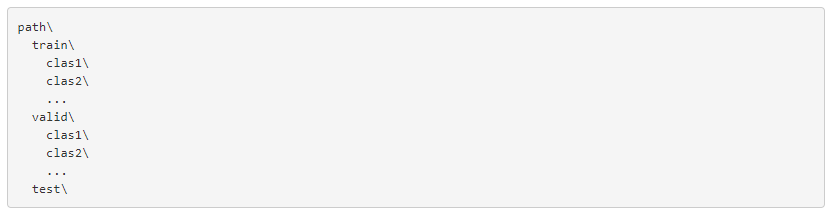<br>
On rentre comme argument le path, train qui ici prend tout, valid_pct qui correspond au pourcentage du dataset que l'on souhaite pour notre set de validation > ici 20%<br>
On définit la size des images pour qu'elles soient toutes de 224, num_workers correspond au nombre de CPUs que nous souhaitons utiliser et normalize afin d'uniformiser les niveaux des images à la même échelle.

In [4]:
np.random.seed(3)
data = ImageDataBunch.from_folder(path, train='.', valid_pct=0.2,
                                 ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

On demande à partir de l'objet data, on affiche les différentes propriétés classes, ici les quatre artistes.

In [5]:
data.classes

['Aivazovsky', 'Cortes', 'Renoir', 'VanGogh']

On demande d'afficher l'échantillon d'images qu'on définit avec les arguments suivant:<br>
On demande quatre colonnes avec rows, et figsize l'affichage des images de la batch.

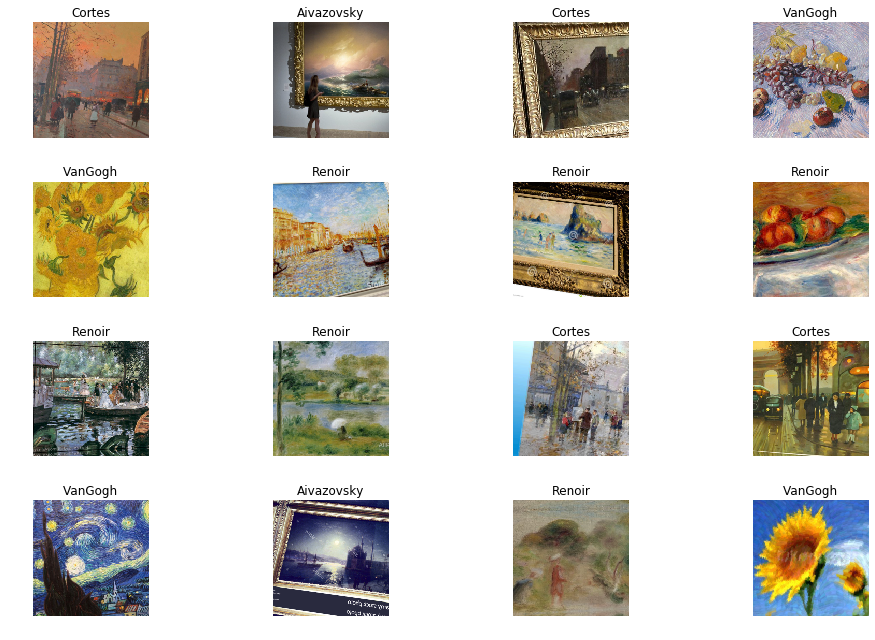

In [6]:
data.show_batch(rows=4, figsize=(14,9))

On lui demande le nom des classes, le nombre de classes, le nombre d'images dans notre training set et dans notre validation set, définit par l'argument valid_pct de la classe ImageDataBunch.

In [7]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Aivazovsky', 'Cortes', 'Renoir', 'VanGogh'], 4, 928, 231)

# 4) Création du réseau de neurone et du modèle

<br>

On initialise notre réseau de neurone avec create_cnn en lui précisant notre dataset, l'architecture ResNet et error_rate qui est notre métric permettant d'évaluer l'efficacité de notre modèle.

In [8]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)

On précise avec torch.device('cuda') que l'on travaille bien avec le GPU et non le CPU.

In [9]:
defaults.device = torch.device('cuda')

On demande à notre modèle d'apprendre avec la classe fit_one_cycle (1cycle policy) et en lui précisant le nombre d'epochs.

In [10]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,1.038067,0.264591,0.922078,00:21
1,0.614245,0.154853,0.956710,00:25
2,0.429870,0.131435,0.956710,00:23
3,0.328123,0.129389,0.961039,00:25


# 5) Nettoyage du dataset

<br>

On importe tous les éléments du module widgets afin de les utiliser pour nettoyer nos données.

In [11]:
from fastai.widgets import *

DatasetFormatter permet de retourner le dataset avec les données sous un bon format et correctement indexé.<br>
from_toplosses permet de prendre les images pour lesquelles le modèle se trompe le plus.

In [12]:
ds, idxs = DatasetFormatter().from_toplosses(learn)

ImageCleaner est un widget qui nous permet de supprimer les images pour lesquelles on recense le plus de loss afin de les supprimer ou de les réassigner dans la bonne classe puis les réassigne dans un fichier cleaned.csv<br>
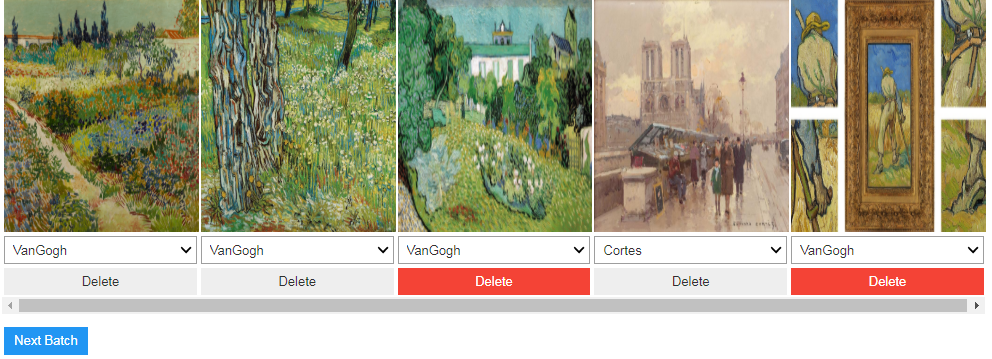

In [13]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

On utilise pandas pour lire le fichier cleaned.csv et on affiche avec head les 5 premières données avec le nom des fichiers et leurs classes.

In [14]:
df = pd.read_csv(path/'cleaned.csv', header='infer')
df.head()

,name,label
0,Cortes/00000216.jpg,Cortes
1,Cortes/00000032.jpg,Cortes
2,Cortes/00000057.jpg,Cortes
3,Cortes/00000075.jpg,Cortes
4,Cortes/00000029.jpg,Cortes


On vérifie que les noms de fichiers ne sont pas corrompus.

In [15]:
df[(df['name'].apply(lambda x: len(x)<5))]

,name,label


# 6) Entrainement du modèle avec le nouveau dataset nettoyé

<br>

On réaffecte un random seed de 8.<br>
On recrée l'ImageDataBunch avec notre nouveau dataset nettoyé.

In [31]:
np.random.seed(3)
db = (ImageList.from_df(df, path)
     .split_by_rand_pct(0.2)
     .label_from_df()
     .transform(get_transforms(), size=224)
     .databunch(bs=9)).normalize(imagenet_stats)
db

ImageDataBunch;

Train: LabelList (717 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Cortes,Cortes,Cortes,Cortes,Cortes
Path: paintings;

Valid: LabelList (179 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Aivazovsky,Aivazovsky,Aivazovsky,VanGogh,Renoir
Path: paintings;

Test: None

Dataset non nettoyé :

In [32]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Aivazovsky', 'Cortes', 'Renoir', 'VanGogh'], 4, 928, 231)

Dataset nettoyé :

In [33]:
db.classes, db.c, len(db.train_ds), len(db.valid_ds)

(['Aivazovsky', 'Cortes', 'Renoir', 'VanGogh'], 4, 717, 179)

On affiche une batch:

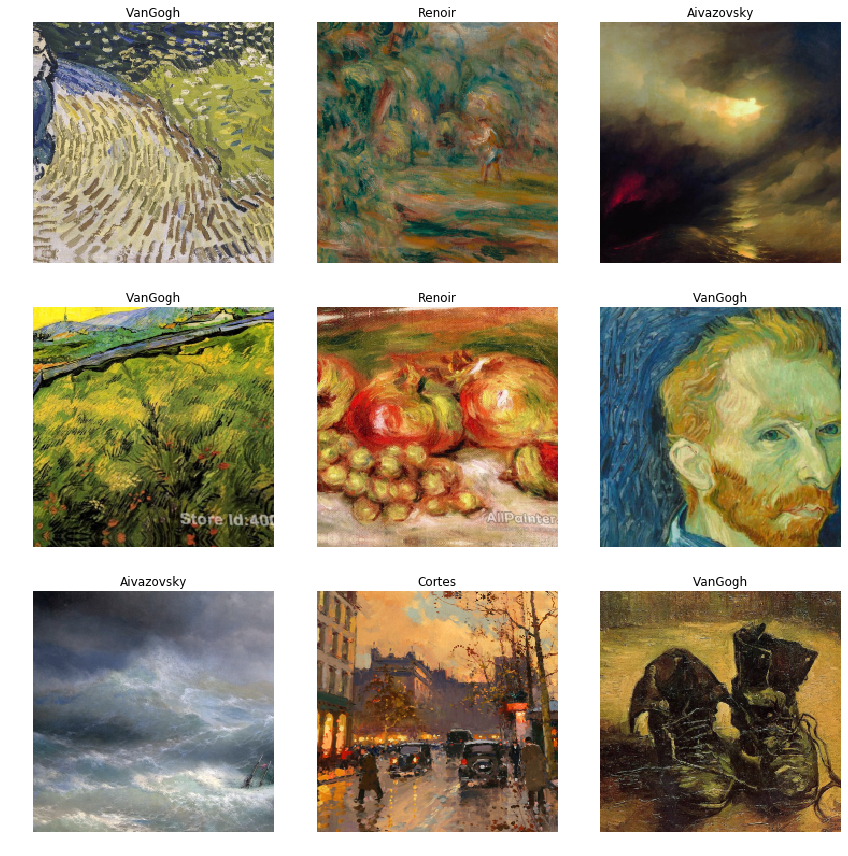

In [38]:
db.show_batch()

In [39]:
learn_data = db

On réentraîne notre nouveau dataset

In [40]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,0.143961,0.270502,0.926407,00:21
1,0.150718,0.335651,0.922078,00:22
2,0.129007,0.123504,0.969697,00:27
3,0.094915,0.105215,0.974026,00:23


In [41]:
learn.save('paintings34_1')

In [42]:
learn.unfreeze()

In [43]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.090882,0.175312,0.943723,00:25


In [44]:
learn.load('paintings34_1')


Learner(data=ImageDataBunch;

Train: LabelList (928 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Cortes,Cortes,Cortes,Cortes,Cortes
Path: paintings;

Valid: LabelList (231 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
VanGogh,Cortes,VanGogh,Cortes,Cortes
Path: paintings;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

Permet de trouver le learning rate qu'on affiche avec recorder.plot

In [45]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


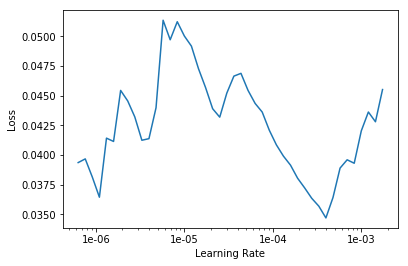

In [46]:
learn.recorder.plot()

On réentraîne le modèle selon l'intervall de learning rate choisi.

In [47]:
learn.fit_one_cycle(4, max_lr=slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.046541,0.088126,0.974026,00:23
1,0.041243,0.072894,0.969697,00:26
2,0.033908,0.067312,0.974026,00:28
3,0.027806,0.068977,0.974026,00:24


On sauvegarde le deuxième modèle.

In [48]:
learn.save('paintings34_2')

ClassificationInterpretation est une fonction FastAI qui permet d'interpreter les résultats des modèles de classification.

In [49]:
interp = ClassificationInterpretation.from_learner(learn)

In [50]:
losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

On affiche les plus hautes pertes pour chaque image.

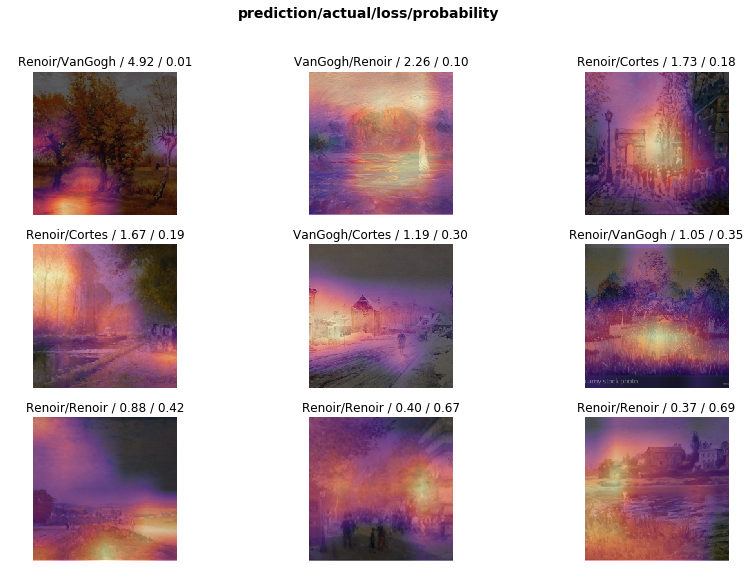

In [51]:
interp.plot_top_losses(9, figsize=(14,9))

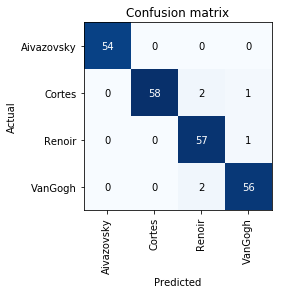

In [52]:
interp.plot_confusion_matrix()

In [53]:
interp.most_confused(min_val=1)

[('Cortes', 'Renoir', 2),
 ('VanGogh', 'Renoir', 2),
 ('Cortes', 'VanGogh', 1),
 ('Renoir', 'VanGogh', 1)]